In [1]:
import pandas as pd
import numpy as np
import mysql.connector
from mysql.connector import Error
from datetime import datetime
import env
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Memuat dataset
df = pd.read_csv("dataset_ori.csv")

# Menampilkan 5 baris pertama dari dataset
df.head()

,reco_id_curr,contract_type_name,gender,own_car_flag,own_realty_flag,children_count,income,loan_body,annuity_payment,goods_price,...,annuity_payment_mean_y,annuity_payment_sum,loan_body_requested_mean,loan_body_requested_sum,loan_body_mean,loan_body_sum,first_payment_mean,first_payment_sum,goods_price_mean,goods_price_sum
0,250865db9679b963f8053cea33eb0f86,Cash loans,M,Y,N,0,180000.0,953460.0,66357.0,900000.0,...,13161.464844,13161.464844,127287.00,127287.0,127287.00,127287.0,0.0,0.0,127287.00,127287.0
1,73e474ce3790236a26bb05cc806b254d,Cash loans,F,N,N,0,85500.0,381528.0,14512.5,315000.0,...,14232.690430,14232.690430,112500.00,112500.0,119925.00,119925.0,0.0,0.0,112500.00,112500.0
2,bbead8b3dd56a68ac6744d0028aca009,Cash loans,M,Y,Y,0,405000.0,1006920.0,42660.0,900000.0,...,13346.730469,13346.730469,138987.00,138987.0,125086.50,125086.5,13900.5,13900.5,138987.00,138987.0
3,ece1f89b0bfae8748f44c138346ad267,Cash loans,F,N,Y,2,81000.0,286704.0,15682.5,247500.0,...,2628.629883,2628.629883,20236.50,20236.5,22239.00,22239.0,0.0,0.0,20236.50,20236.5
4,16a5efff61d95fd7f8de14d186a69c01,Cash loans,F,N,Y,2,99000.0,450000.0,30573.0,450000.0,...,1039.747559,4158.990234,7863.75,31455.0,7526.25,30105.0,337.5,1350.0,7863.75,31455.0


In [4]:
# Mendapatkan informasi dasar dari dataset
info_df = df.info()

# Menghitung jumlah missing values untuk setiap kolom
missing_values = df.isnull().sum()

missing_values_df = pd.DataFrame({
    'Column Name': missing_values.index,
    'Missing Values': missing_values.values,
    'Percentage Missing (%)': (missing_values.values / len(df)) * 100
}).sort_values(by='Percentage Missing (%)', ascending=False)

missing_values_df.head(10)  # Menampilkan 10 kolom dengan persentase missing value tertinggi

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95964 entries, 0 to 95963
Columns: 151 entries, reco_id_curr to goods_price_sum
dtypes: float64(111), int64(24), object(16)
memory usage: 110.6+ MB


,Column Name,Missing Values,Percentage Missing (%)
115,Active_x,95964,100.0
109,credit_sum_sum,95964,100.0
116,Closed,95964,100.0
117,Sold,95964,100.0
118,Bad_Debt,95964,100.0
114,annuity_payment_mean_x,95964,100.0
112,credit_sum_debt_sum,95964,100.0
111,credit_sum_debt_mean,95964,100.0
110,credit_sum_overdue_mean,95964,100.0
113,credit_sum_limit_mean,95964,100.0


In [5]:
# Mendapatkan deskripsi statistik dari kolom-kolom numerik
numeric_description = df.describe()

# Identifikasi kolom-kolom kategorikal dan melihat beberapa nilai uniknya
categorical_columns = df.select_dtypes(include=['object']).columns
unique_values_categorical = {col: df[col].unique()[:5] for col in categorical_columns}  # Menampilkan 5 nilai unik pertama

numeric_description, unique_values_categorical


(       children_count        income     loan_body  annuity_payment  \
 count    95964.000000  9.596400e+04  9.596400e+04     95964.000000   
 mean         0.430547  1.702946e+05  5.991149e+05     27078.061252   
 std          0.729839  3.892335e+05  3.933473e+05     13999.263526   
 min          0.000000  2.700000e+04  4.500000e+04         0.000000   
 25%          0.000000  1.125000e+05  2.700000e+05     16681.500000   
 50%          0.000000  1.575000e+05  5.212800e+05     25033.500000   
 75%          1.000000  2.025000e+05  8.086500e+05     34636.500000   
 max         19.000000  1.170000e+08  3.956270e+06    220298.000000   
 
         goods_price  population_relative_region    days_birth  days_employed  \
 count  9.596400e+04                95964.000000  95964.000000   95964.000000   
 mean   5.378899e+05                    0.020597 -16136.581854   64266.267809   
 std    3.601491e+05                    0.013473   4306.675433  141744.609096   
 min    0.000000e+00               

In [6]:
# Menghapus kolom dengan 100% missing values
columns_to_drop = missing_values_df[missing_values_df["Percentage Missing (%)"] == 100]["Column Name"].tolist()
df_cleaned = df.drop(columns=columns_to_drop)

# Cek kembali informasi dari dataset setelah menghapus kolom
info_cleaned_df = df_cleaned.info()

# Menghitung ulang jumlah missing values untuk setiap kolom setelah pembersihan
missing_values_cleaned = df_cleaned.isnull().sum()
missing_values_cleaned_df = pd.DataFrame({
    'Column Name': missing_values_cleaned.index,
    'Missing Values': missing_values_cleaned.values,
    'Percentage Missing (%)': (missing_values_cleaned.values / len(df_cleaned)) * 100
}).sort_values(by='Percentage Missing (%)', ascending=False)

missing_values_cleaned_df.head(10)  # Menampilkan 10 kolom dengan persentase missing value tertinggi


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95964 entries, 0 to 95963
Columns: 137 entries, reco_id_curr to goods_price_sum
dtypes: float64(97), int64(24), object(16)
memory usage: 100.3+ MB


,Column Name,Missing Values,Percentage Missing (%)
87,mode_walls_material,48876,50.931599
85,mode_house_type,48281,50.311575
88,emergency_state_mode,45608,47.526156
105,Unnamed: 0_y,34094,35.527906
124,Demand,34094,35.527906
115,reco_dpd_sum,34094,35.527906
116,reco_dpd_median,34094,35.527906
117,reco_dpd_def_mean,34094,35.527906
118,reco_dpd_def_sum,34094,35.527906
119,reco_dpd_def_median,34094,35.527906


In [7]:
# Menghapus kolom dengan missing values di atas 40%
threshold = 40
columns_to_drop_40 = missing_values_cleaned_df[missing_values_cleaned_df["Percentage Missing (%)"] > threshold]["Column Name"].tolist()
df_cleaned_40 = df_cleaned.drop(columns=columns_to_drop_40)

# Cek kembali informasi dari dataset setelah menghapus kolom
info_cleaned_40_df = df_cleaned_40.info()

# Menghitung ulang jumlah missing values untuk setiap kolom setelah pembersihan
missing_values_cleaned_40 = df_cleaned_40.isnull().sum()
missing_values_cleaned_40_df = pd.DataFrame({
    'Column Name': missing_values_cleaned_40.index,
    'Missing Values': missing_values_cleaned_40.values,
    'Percentage Missing (%)': (missing_values_cleaned_40.values / len(df_cleaned_40)) * 100
}).sort_values(by='Percentage Missing (%)', ascending=False)

missing_values_cleaned_40_df.head(10)  # Menampilkan 10 kolom dengan persentase missing value tertinggi


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95964 entries, 0 to 95963
Columns: 134 entries, reco_id_curr to goods_price_sum
dtypes: float64(97), int64(24), object(13)
memory usage: 98.1+ MB


,Column Name,Missing Values,Percentage Missing (%)
102,Unnamed: 0_y,34094,35.527906
113,reco_dpd_median,34094,35.527906
115,reco_dpd_def_sum,34094,35.527906
116,reco_dpd_def_median,34094,35.527906
117,Active_y,34094,35.527906
118,Completed,34094,35.527906
119,Returned to the store,34094,35.527906
120,Signed,34094,35.527906
121,Demand,34094,35.527906
122,Approved,34094,35.527906


In [8]:
# Mengimputasi kolom numerik dengan median
for col in df_cleaned_40.select_dtypes(include=['float64', 'int64']).columns:
    df_cleaned_40[col].fillna(df_cleaned_40[col].median(), inplace=True)

# Mengimputasi kolom kategorikal dengan modus
for col in df_cleaned_40.select_dtypes(include=['object']).columns:
    df_cleaned_40[col].fillna(df_cleaned_40[col].mode()[0], inplace=True)

# Cek ulang missing values setelah imputasi
missing_values_after_imputation = df_cleaned_40.isnull().sum().sum()

missing_values_after_imputation


0

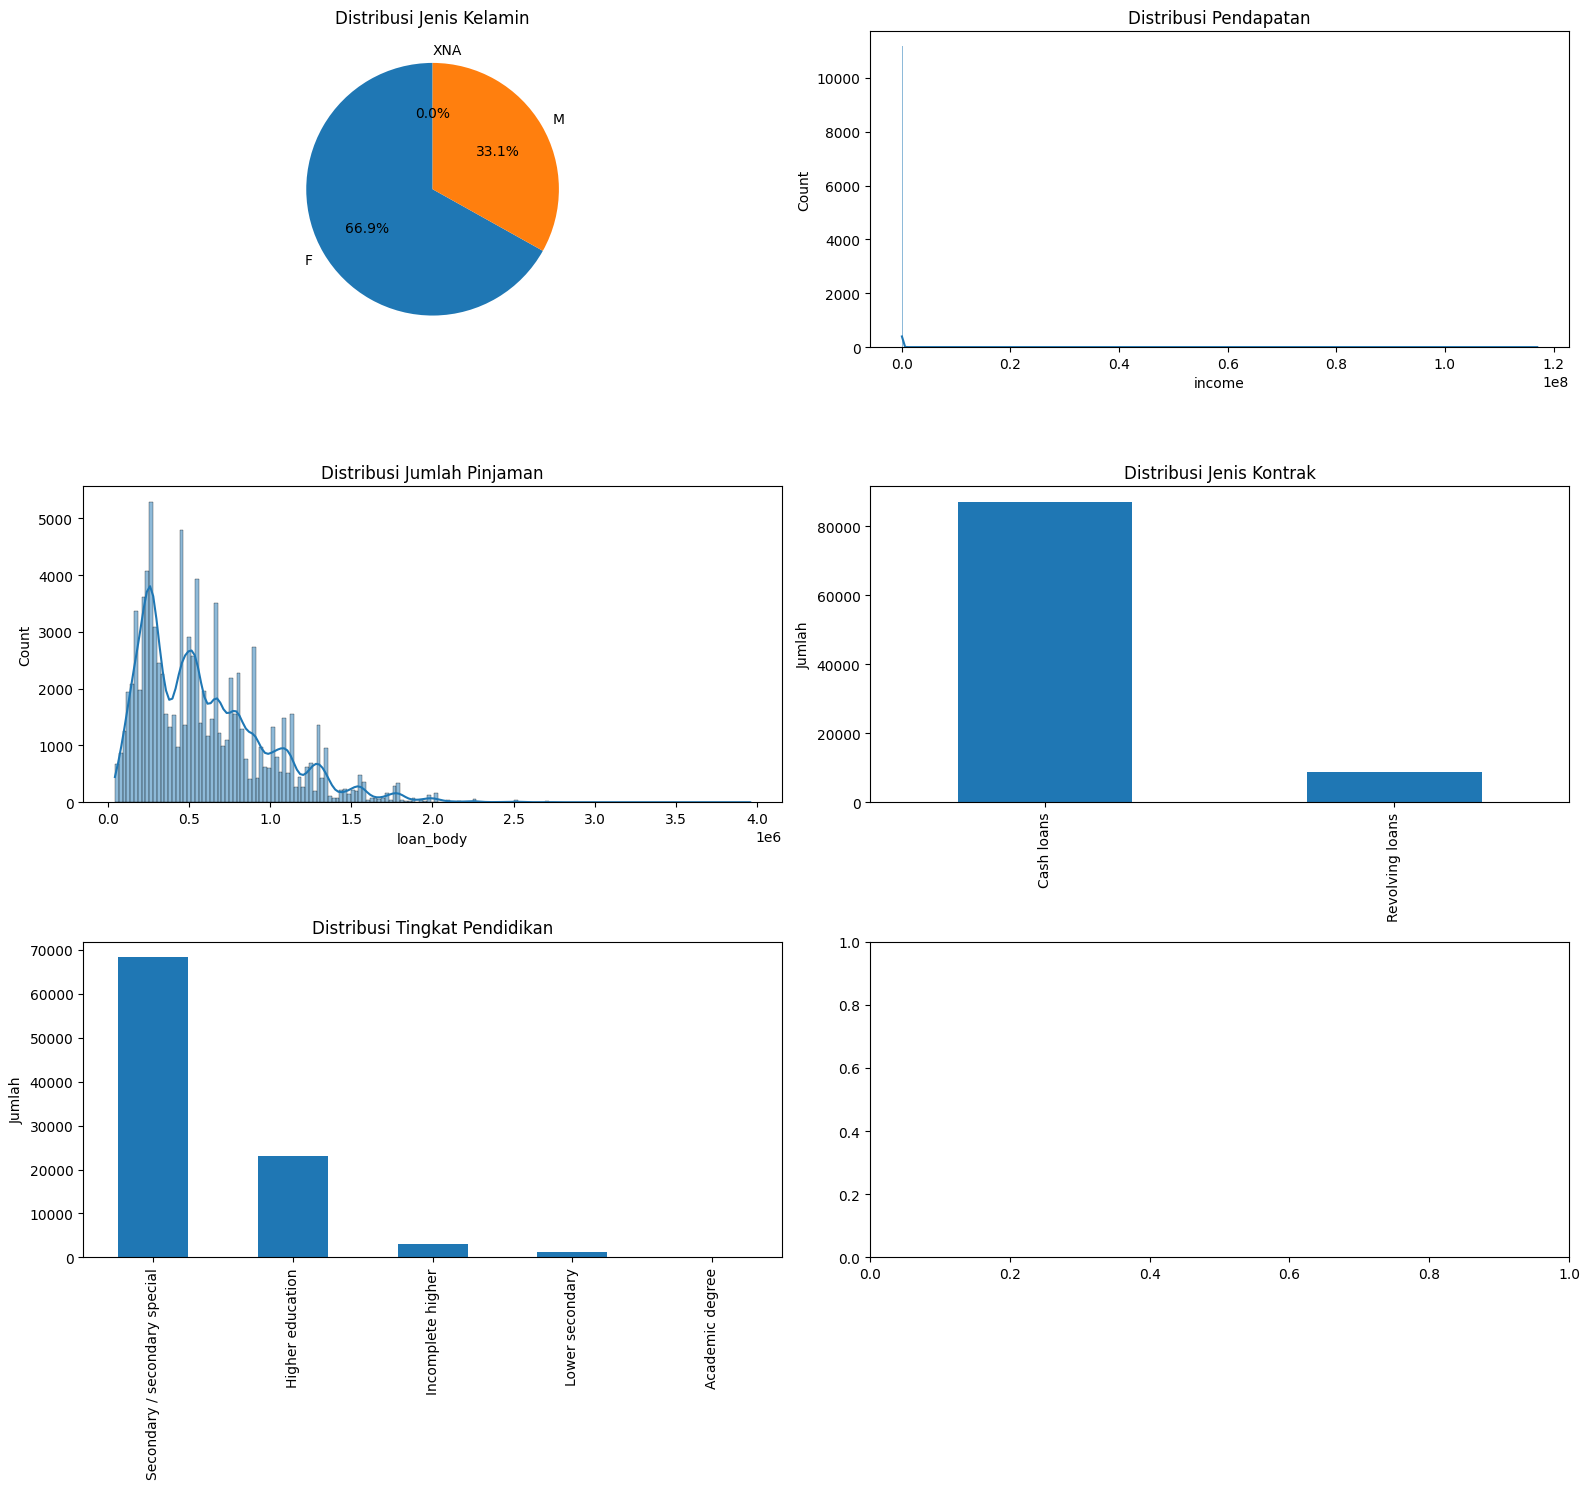

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Membuat visualisasi
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 15))

# Pie chart untuk kolom 'gender'
df_cleaned_40['gender'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0, 0], startangle=90)
axes[0, 0].set_title('Distribusi Jenis Kelamin')
axes[0, 0].set_ylabel('')

# Histogram untuk kolom 'income'
sns.histplot(df_cleaned_40['income'], ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Distribusi Pendapatan')

# Histogram untuk kolom 'loan_body'
sns.histplot(df_cleaned_40['loan_body'], ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Distribusi Jumlah Pinjaman')

# Bar chart untuk kolom 'contract_type_name'
df_cleaned_40['contract_type_name'].value_counts().plot.bar(ax=axes[1, 1])
axes[1, 1].set_title('Distribusi Jenis Kontrak')
axes[1, 1].set_ylabel('Jumlah')

# Bar chart untuk kolom 'education_type_name'
df_cleaned_40['education_type_name'].value_counts().plot.bar(ax=axes[2, 0])
axes[2, 0].set_title('Distribusi Tingkat Pendidikan')
axes[2, 0].set_ylabel('Jumlah')

# Mengatur layout dan menampilkan visualisasi
plt.tight_layout()
plt.show()


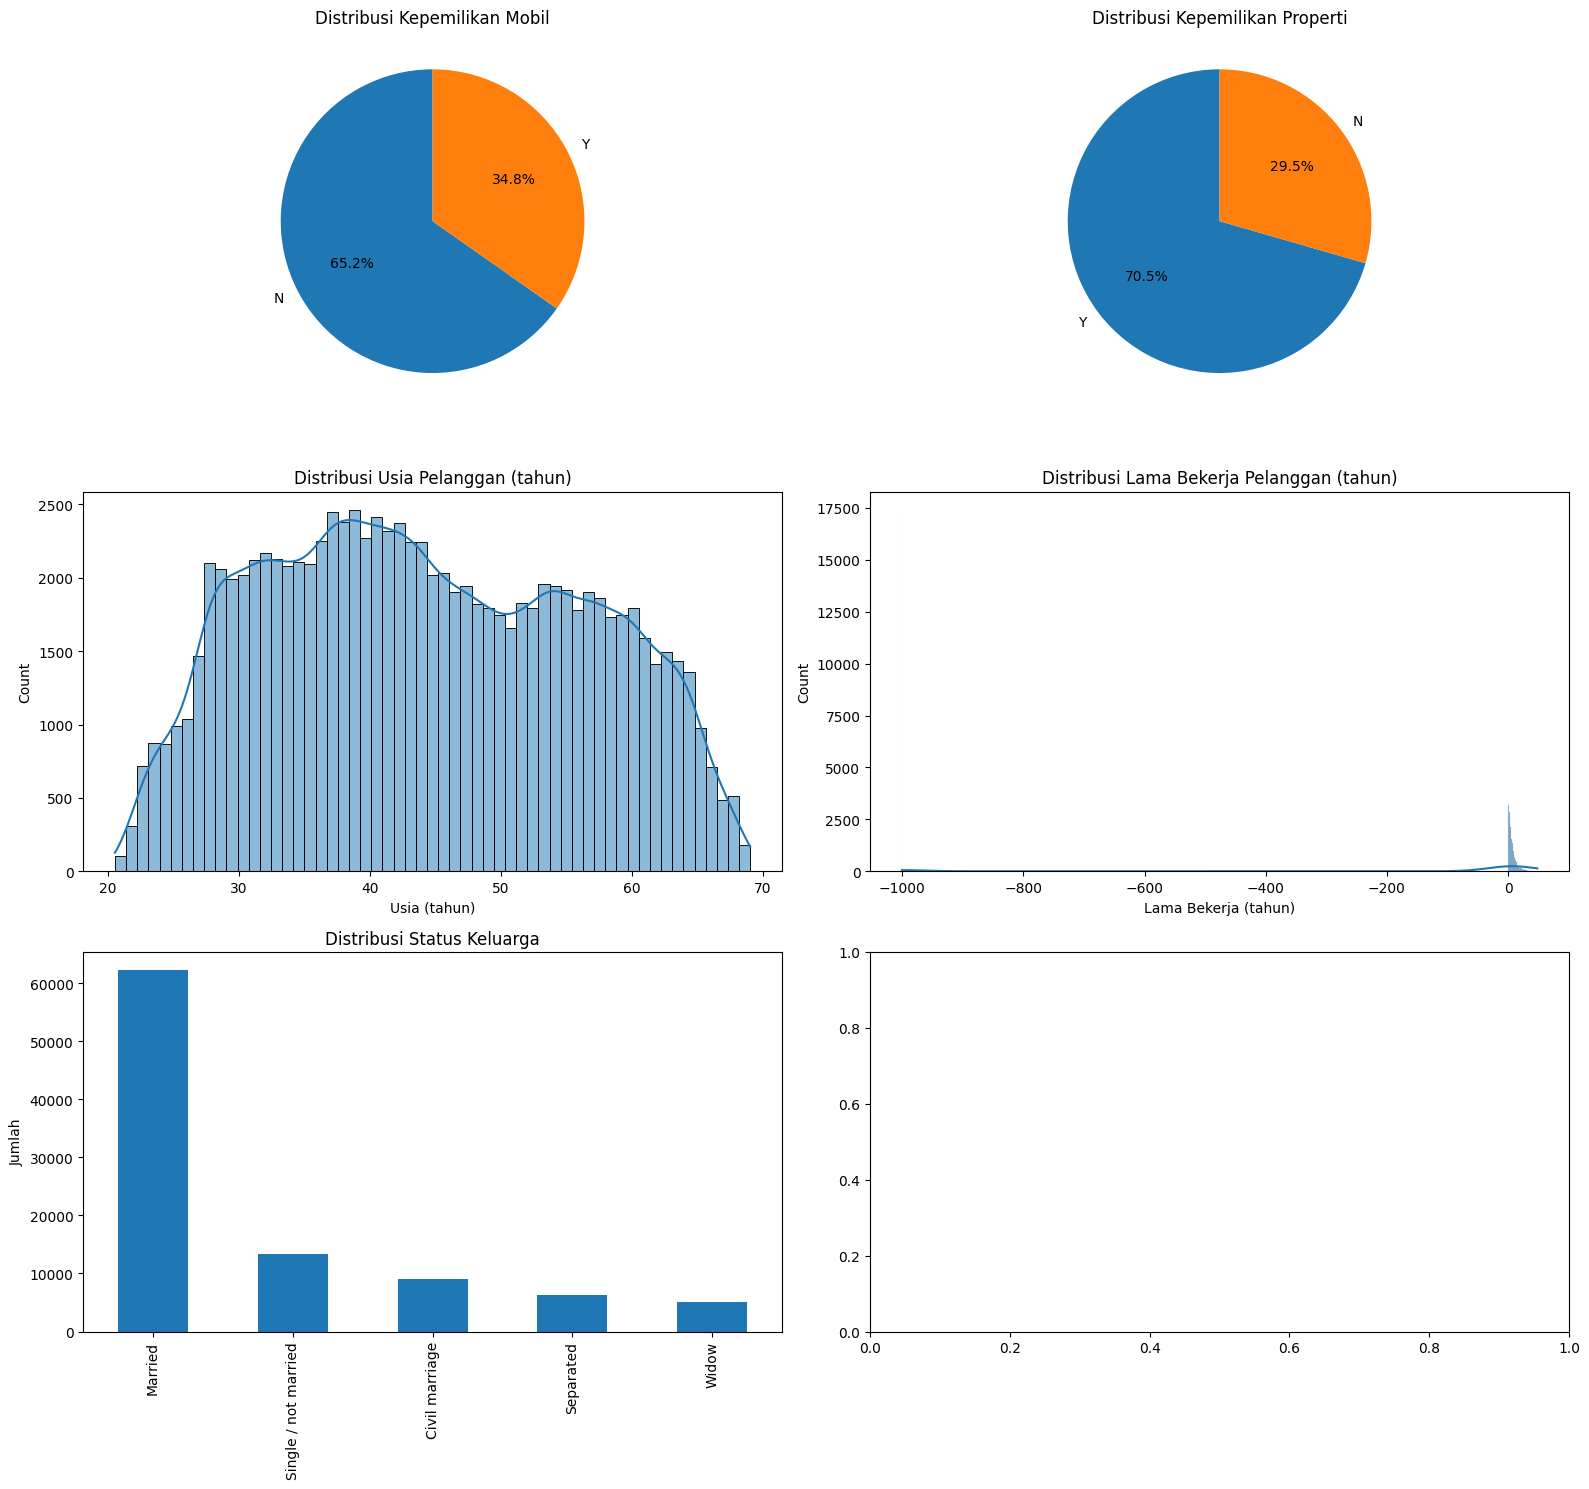

In [10]:
# Membuat visualisasi untuk kolom tambahan
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 15))

# Pie chart untuk kolom 'own_car_flag'
df_cleaned_40['own_car_flag'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0, 0], startangle=90)
axes[0, 0].set_title('Distribusi Kepemilikan Mobil')
axes[0, 0].set_ylabel('')

# Pie chart untuk kolom 'own_realty_flag'
df_cleaned_40['own_realty_flag'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0, 1], startangle=90)
axes[0, 1].set_title('Distribusi Kepemilikan Properti')
axes[0, 1].set_ylabel('')

# Histogram untuk kolom 'days_birth' (dikonversi ke tahun)
sns.histplot(df_cleaned_40['days_birth'] / -365, ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Distribusi Usia Pelanggan (tahun)')
axes[1, 0].set_xlabel('Usia (tahun)')

# Histogram untuk kolom 'days_employed' (dikonversi ke tahun)
sns.histplot(df_cleaned_40['days_employed'] / -365, ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Distribusi Lama Bekerja Pelanggan (tahun)')
axes[1, 1].set_xlabel('Lama Bekerja (tahun)')

# Bar chart untuk kolom 'family_status_name'
df_cleaned_40['family_status_name'].value_counts().plot.bar(ax=axes[2, 0])
axes[2, 0].set_title('Distribusi Status Keluarga')
axes[2, 0].set_ylabel('Jumlah')

# Mengatur layout dan menampilkan visualisasi
plt.tight_layout()
plt.show()

In [11]:
# Menghitung jumlah baris dimana days_employed lebih besar dari days_birth (yang berarti inkonsisten)
inconsistent_data = df_cleaned_40[df_cleaned_40['days_employed'] > df_cleaned_40['days_birth']]

# Menampilkan statistik deskriptif untuk data yang inkonsisten
inconsistent_data_describe = inconsistent_data[['days_birth', 'days_employed']].describe()

# Menghitung persentase data yang inkonsisten
percentage_inconsistent = len(inconsistent_data) / len(df_cleaned_40) * 100

inconsistent_data_describe, percentage_inconsistent


(         days_birth  days_employed
 count  95964.000000   95964.000000
 mean  -16136.581854   64266.267809
 std     4306.675433  141744.609096
 min   -25201.000000  -17583.000000
 25%   -19739.000000   -2874.000000
 50%   -15822.000000   -1289.000000
 75%   -12605.000000    -308.000000
 max    -7489.000000  365243.000000,
 100.0)

In [12]:
# Menghapus kolom 'days_employed'
df_cleaned_40.drop(columns=['days_employed'], inplace=True)

# Cek kembali kolom-kolom yang tersisa di dataset
remaining_columns = df_cleaned_40.columns

remaining_columns


Index(['reco_id_curr', 'contract_type_name', 'gender', 'own_car_flag',
       'own_realty_flag', 'children_count', 'income', 'loan_body',
       'annuity_payment', 'goods_price',
       ...
       'annuity_payment_mean_y', 'annuity_payment_sum',
       'loan_body_requested_mean', 'loan_body_requested_sum', 'loan_body_mean',
       'loan_body_sum', 'first_payment_mean', 'first_payment_sum',
       'goods_price_mean', 'goods_price_sum'],
      dtype='object', length=133)

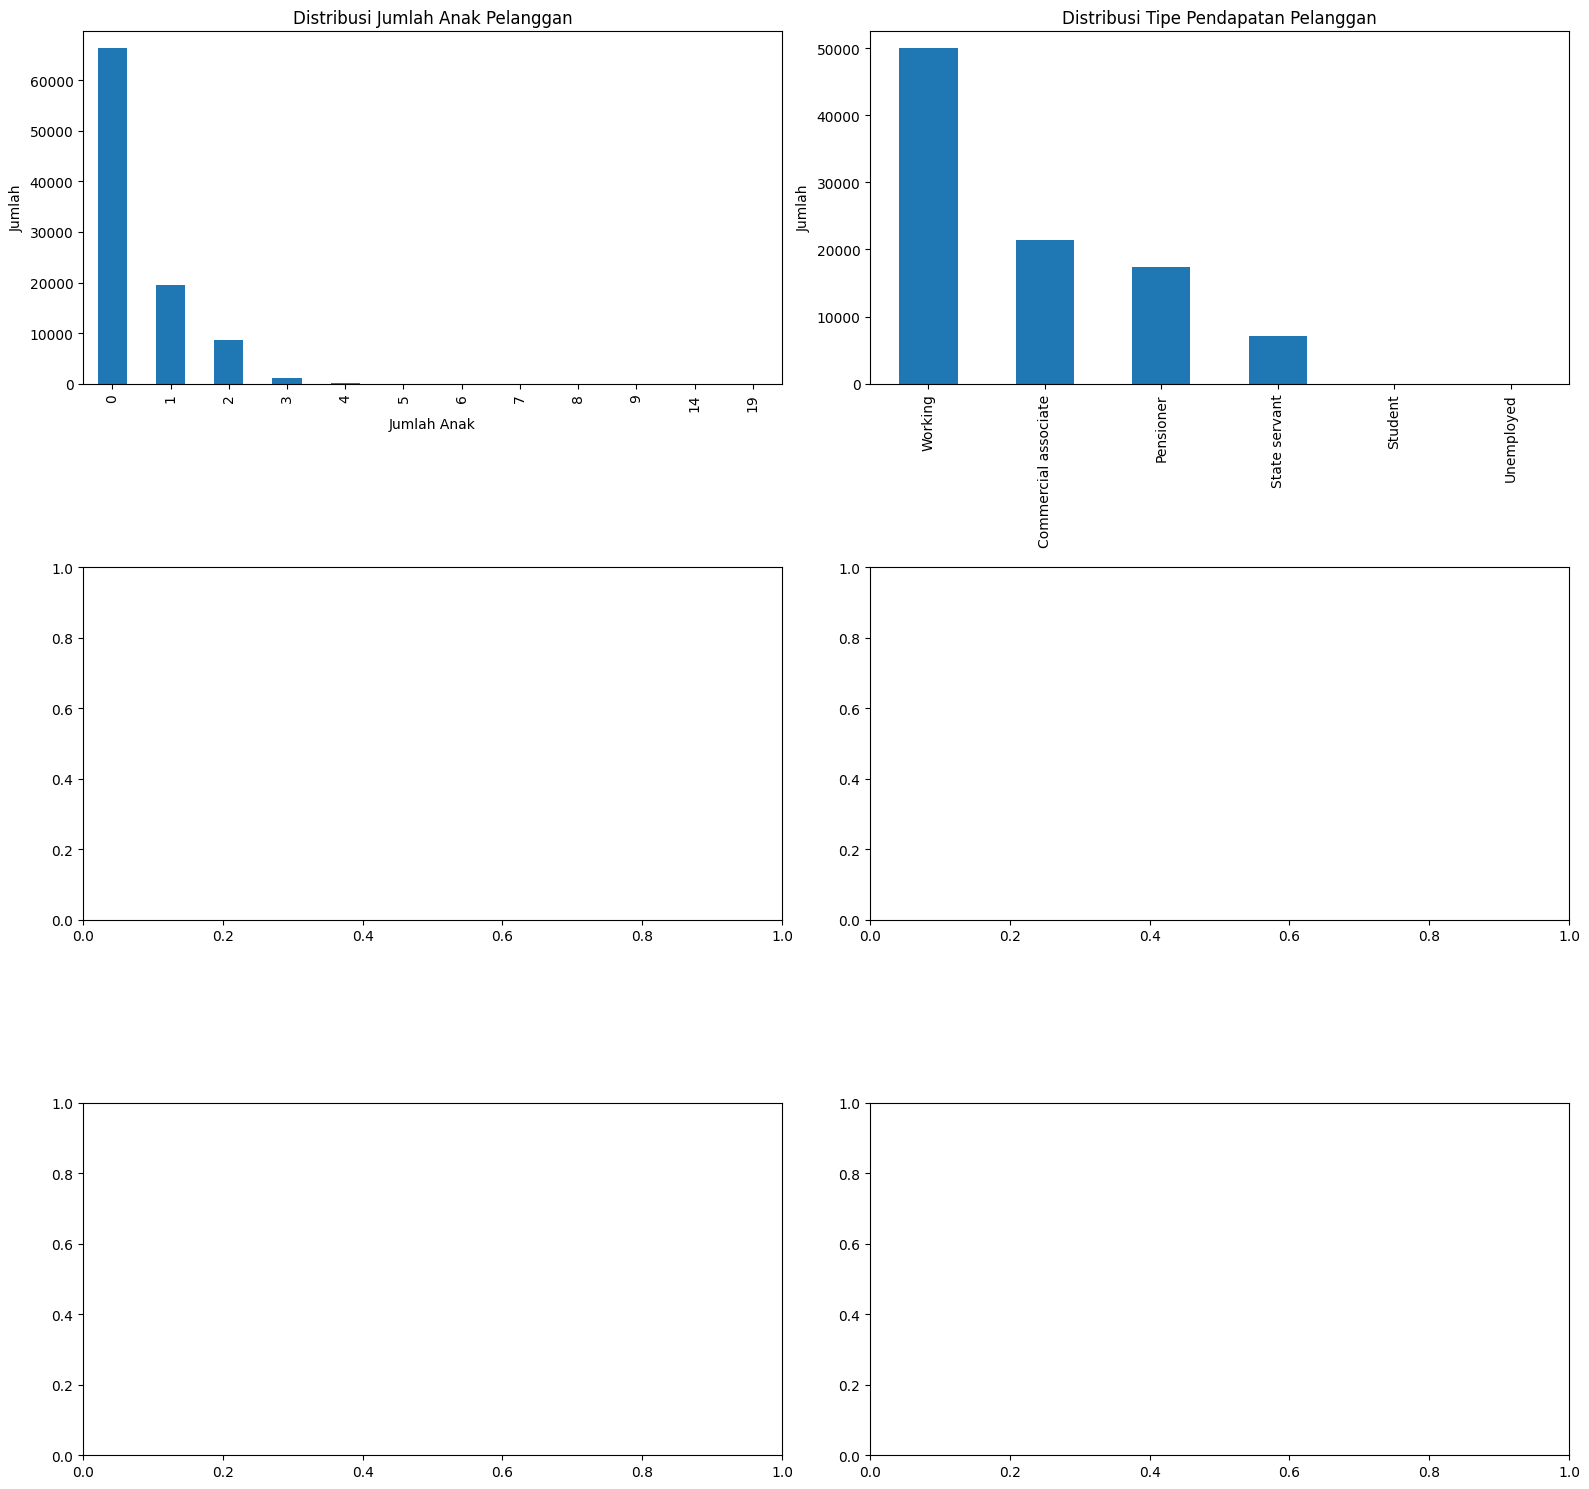

In [17]:
# Membuat visualisasi untuk kolom tambahan dengan perbaikan
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 15))

# Bar chart untuk kolom 'children_count'
df_cleaned_40['children_count'].value_counts().sort_index().plot.bar(ax=axes[0, 0])
axes[0, 0].set_title('Distribusi Jumlah Anak Pelanggan')
axes[0, 0].set_xlabel('Jumlah Anak')
axes[0, 0].set_ylabel('Jumlah')

# Bar chart untuk kolom 'income_type_name'
df_cleaned_40['income_type_name'].value_counts().plot.bar(ax=axes[0, 1])
axes[0, 1].set_title('Distribusi Tipe Pendapatan Pelanggan')
axes[0, 1].set_ylabel('Jumlah')

# Mengatur layout dan menampilkan visualisasi
plt.tight_layout()
plt.show()


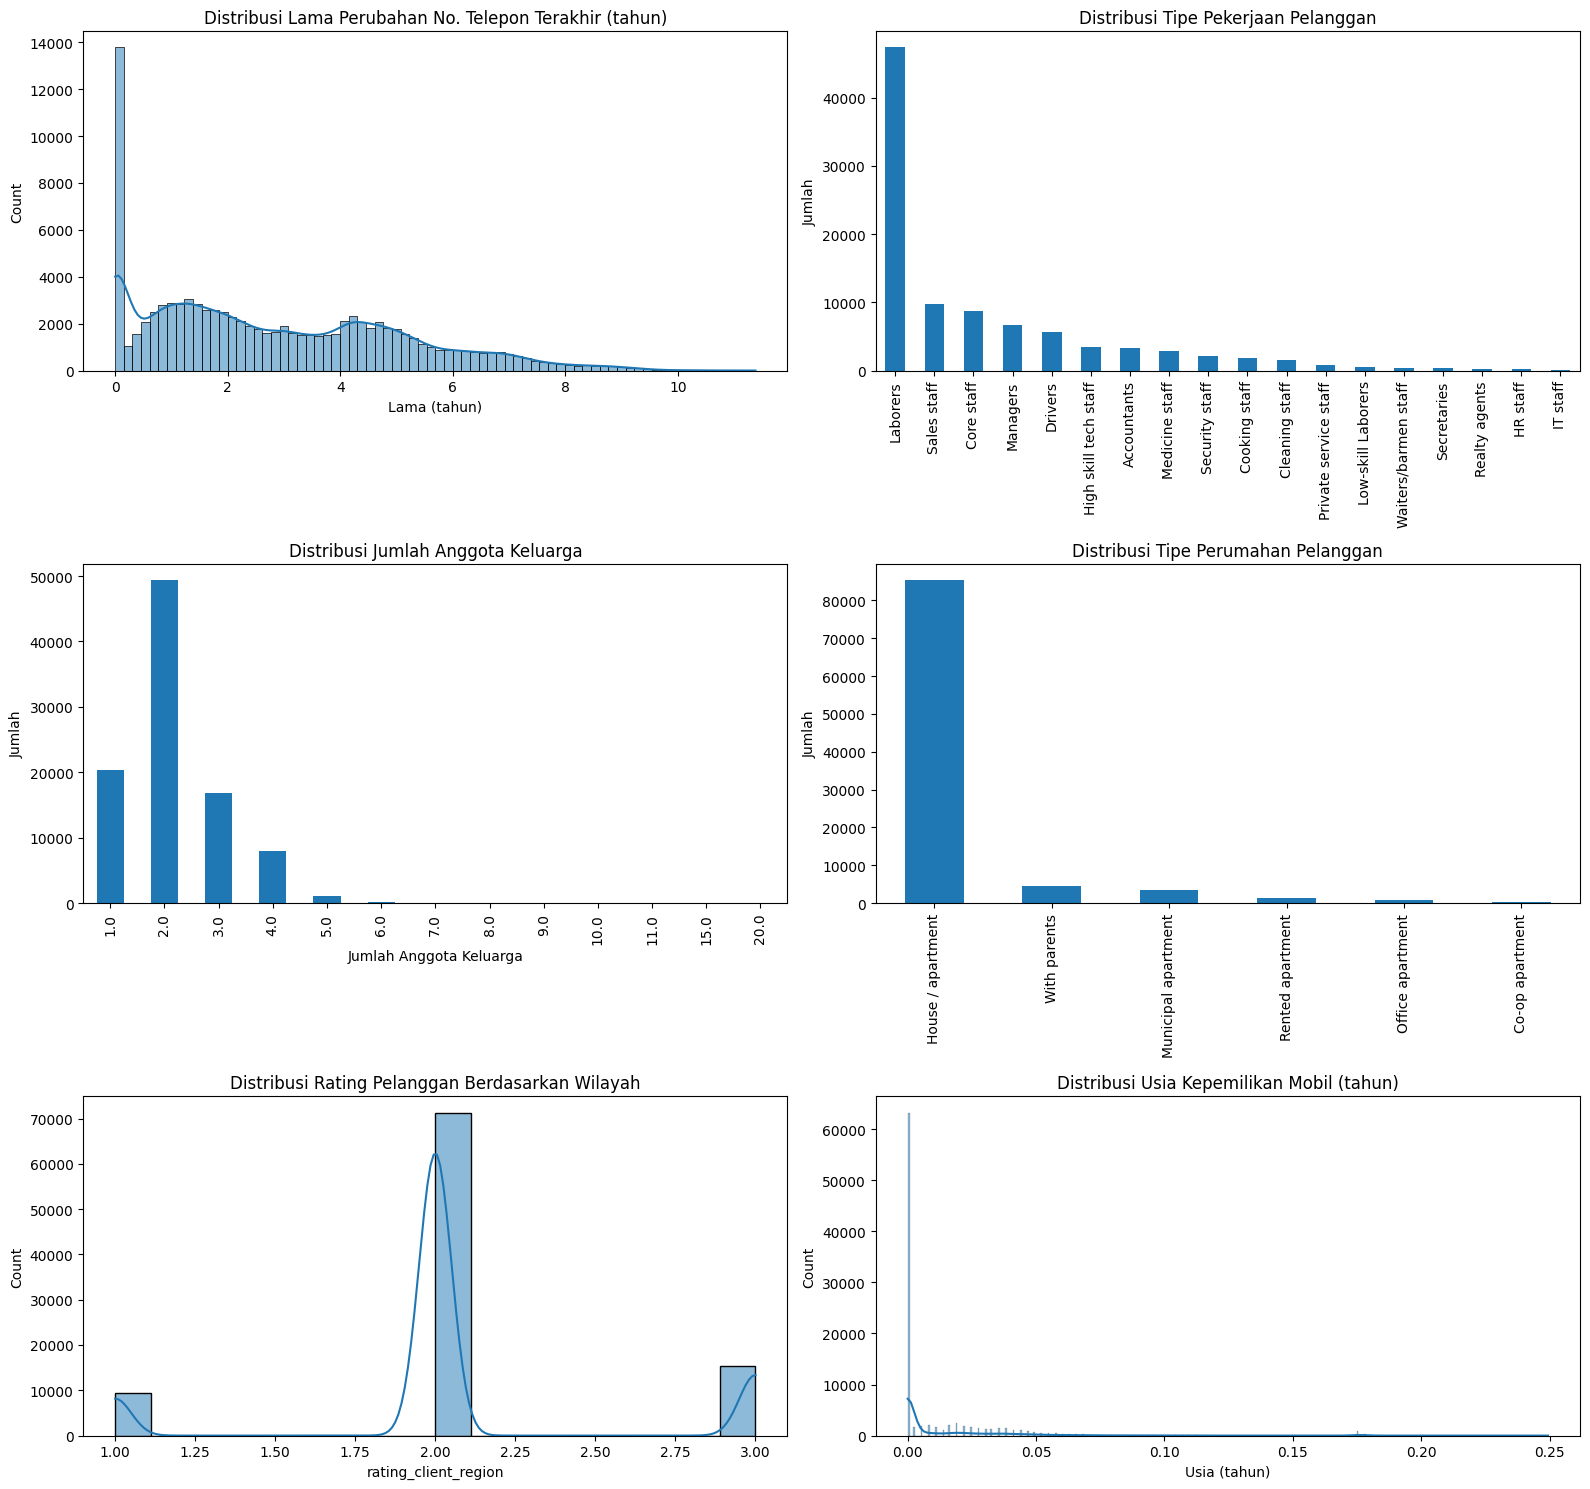

In [18]:
# Membuat visualisasi untuk kolom yang dipilih
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 15))

# Histogram untuk kolom 'last_phone_number_change' (dikonversi ke tahun)
sns.histplot(df_cleaned_40['last_phone_number_change'] / -365, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribusi Lama Perubahan No. Telepon Terakhir (tahun)')
axes[0, 0].set_xlabel('Lama (tahun)')

# Bar chart untuk kolom 'type_of_occupation'
df_cleaned_40['type_of_occupation'].value_counts().plot.bar(ax=axes[0, 1])
axes[0, 1].set_title('Distribusi Tipe Pekerjaan Pelanggan')
axes[0, 1].set_ylabel('Jumlah')

# Bar chart untuk kolom 'family_members__count'
df_cleaned_40['family_members__count'].value_counts().sort_index().plot.bar(ax=axes[1, 0])
axes[1, 0].set_title('Distribusi Jumlah Anggota Keluarga')
axes[1, 0].set_xlabel('Jumlah Anggota Keluarga')
axes[1, 0].set_ylabel('Jumlah')

# Bar chart untuk kolom 'housing_type_name'
df_cleaned_40['housing_type_name'].value_counts().plot.bar(ax=axes[1, 1])
axes[1, 1].set_title('Distribusi Tipe Perumahan Pelanggan')
axes[1, 1].set_ylabel('Jumlah')

# Histogram untuk kolom 'rating_client_region'
sns.histplot(df_cleaned_40['rating_client_region'], ax=axes[2, 0], kde=True)
axes[2, 0].set_title('Distribusi Rating Pelanggan Berdasarkan Wilayah')

# Histogram untuk kolom 'age_own_car' (dikonversi ke tahun)
sns.histplot(df_cleaned_40['age_own_car'] / 365, ax=axes[2, 1], kde=True)
axes[2, 1].set_title('Distribusi Usia Kepemilikan Mobil (tahun)')
axes[2, 1].set_xlabel('Usia (tahun)')

# Mengatur layout dan menampilkan visualisasi
plt.tight_layout()
plt.show()


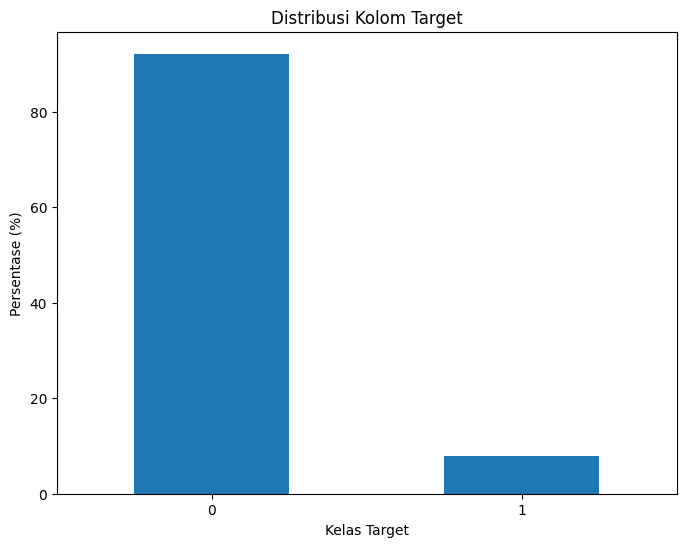

0    92.153307
1     7.846693
Name: target, dtype: float64

In [19]:
# Memeriksa distribusi dari kolom target
target_distribution = df_cleaned_40['target'].value_counts(normalize=True) * 100

# Visualisasi distribusi target
plt.figure(figsize=(8, 6))
target_distribution.plot.bar()
plt.title('Distribusi Kolom Target')
plt.xlabel('Kelas Target')
plt.ylabel('Persentase (%)')
plt.xticks(rotation=0)
plt.show()

target_distribution


C:\Users\basnugroho\AppData\Local\Temp\ipykernel_463488\2901569459.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df_cleaned_40.corr()['target'].sort_values(ascending=False)


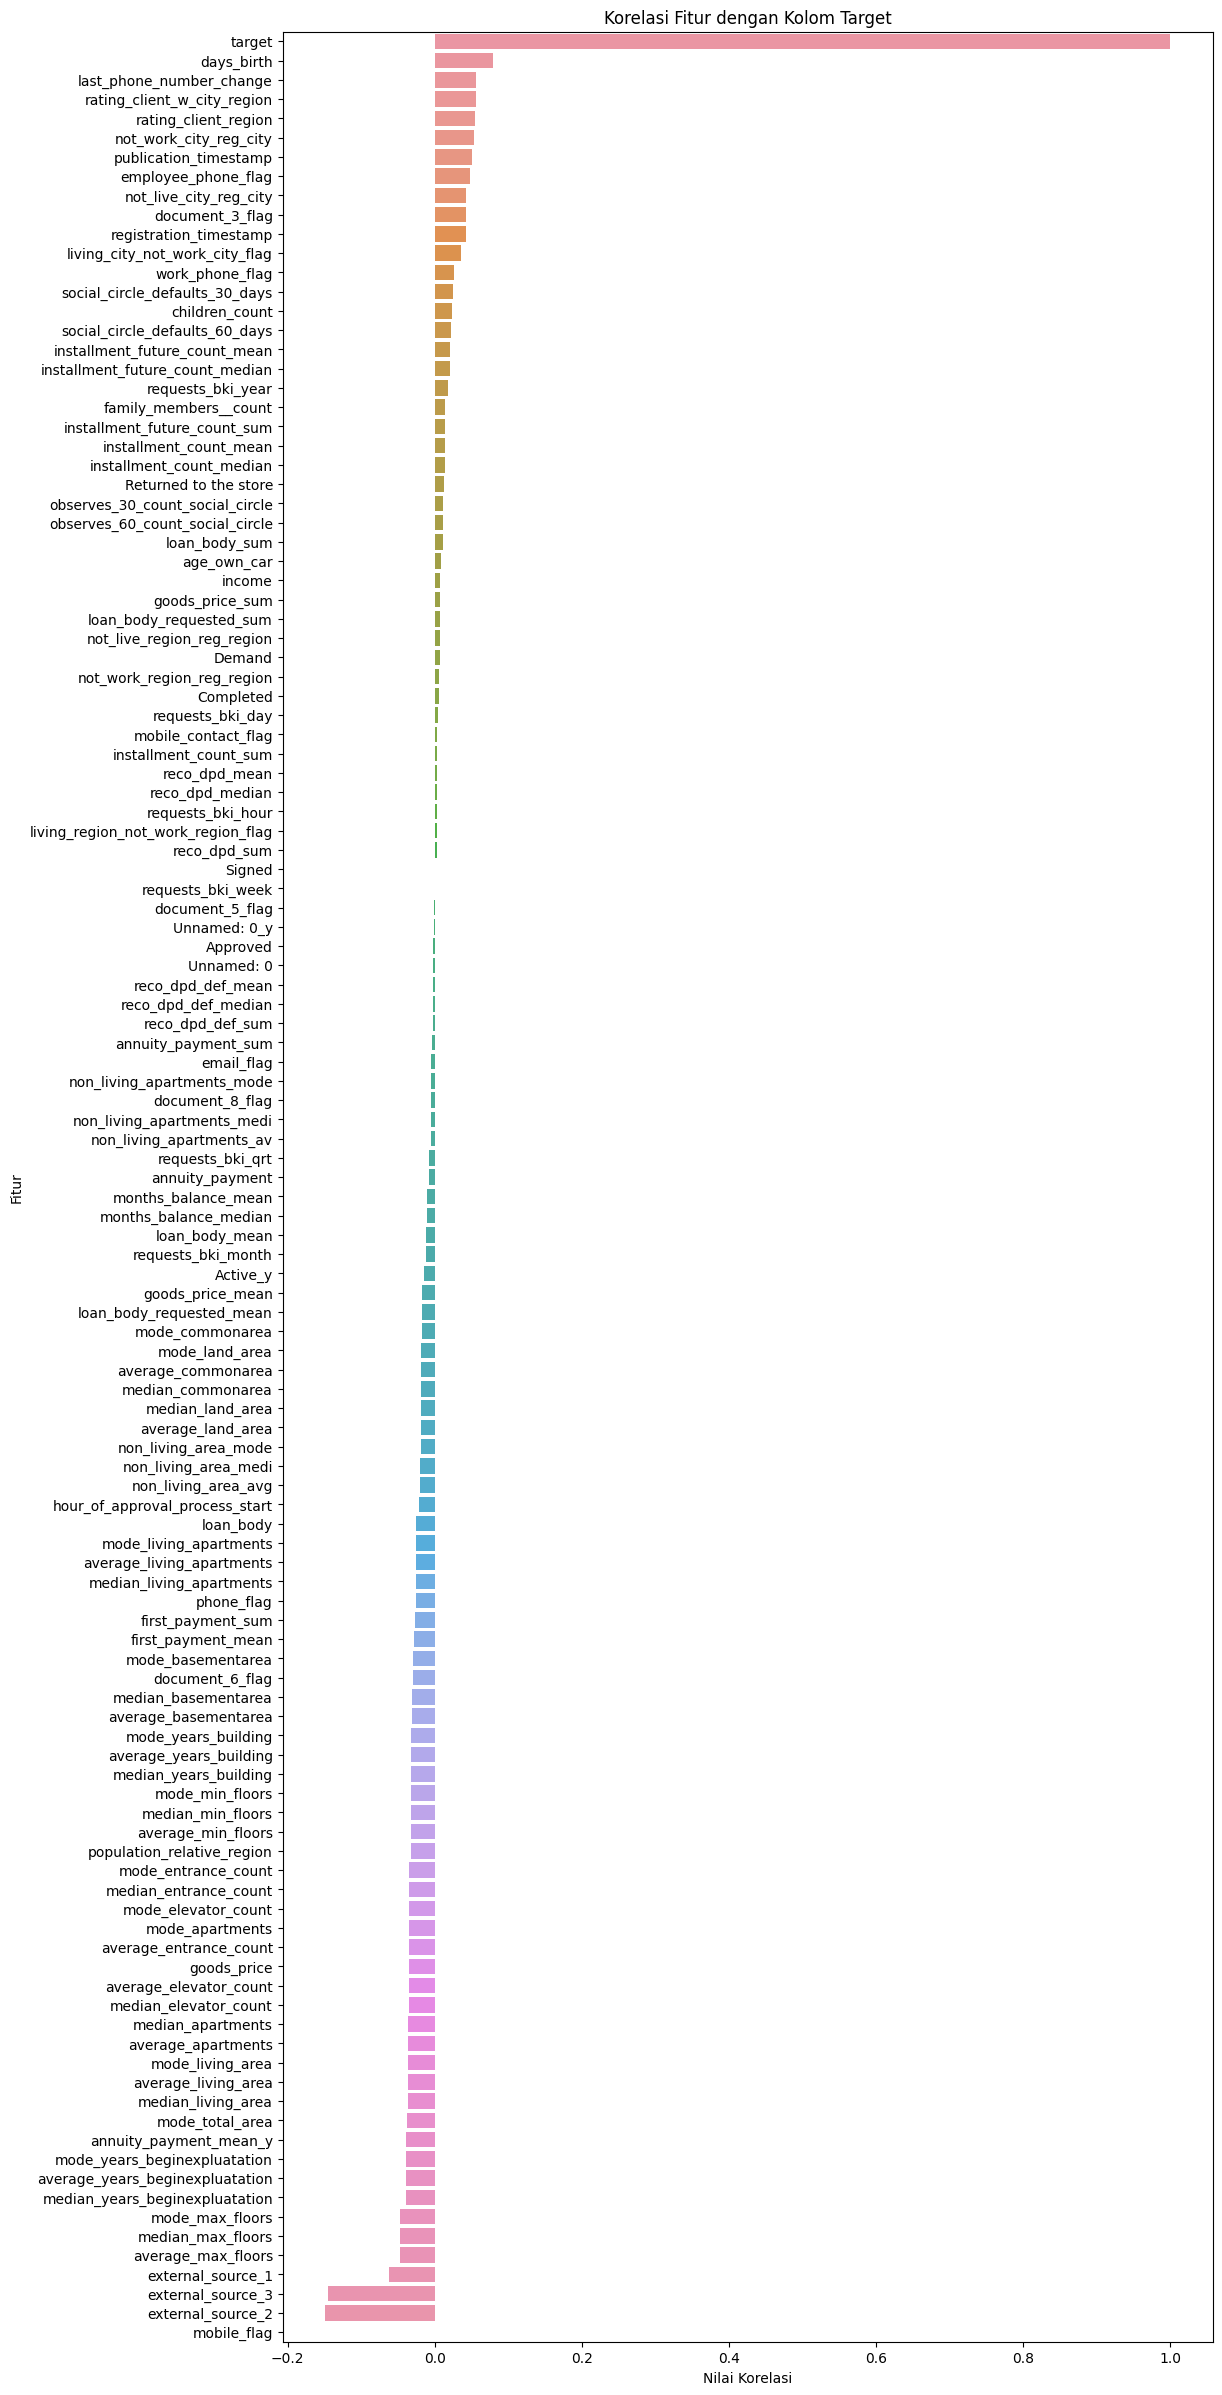

target                         1.000000
days_birth                     0.078851
last_phone_number_change       0.056370
rating_client_w_city_region    0.055721
rating_client_region           0.053967
                                 ...   
average_max_floors            -0.047879
external_source_1             -0.061992
external_source_3             -0.145633
external_source_2             -0.149384
mobile_flag                         NaN
Name: target, Length: 120, dtype: float64

In [20]:
# Menghitung korelasi antara fitur numerik dengan kolom target
correlations = df_cleaned_40.corr()['target'].sort_values(ascending=False)

# Membuat visualisasi korelasi
plt.figure(figsize=(12, 30))
sns.barplot(x=correlations.values, y=correlations.index, orient='h')
plt.title('Korelasi Fitur dengan Kolom Target')
plt.xlabel('Nilai Korelasi')
plt.ylabel('Fitur')
plt.show()

correlations


In [21]:
# Menentukan threshold korelasi
correlation_threshold = 0.05

# Menyaring fitur dengan korelasi absolut di atas threshold
relevant_features = correlations[correlations.abs() > correlation_threshold].index

# Menyaring dataset untuk hanya fitur yang relevan
df_reduced_corr = df_cleaned_40[relevant_features]

# Menampilkan jumlah fitur sebelum dan sesudah penyaringan
num_features_before = df_cleaned_40.shape[1]
num_features_after = df_reduced_corr.shape[1]

num_features_before, num_features_after


(133, 9)

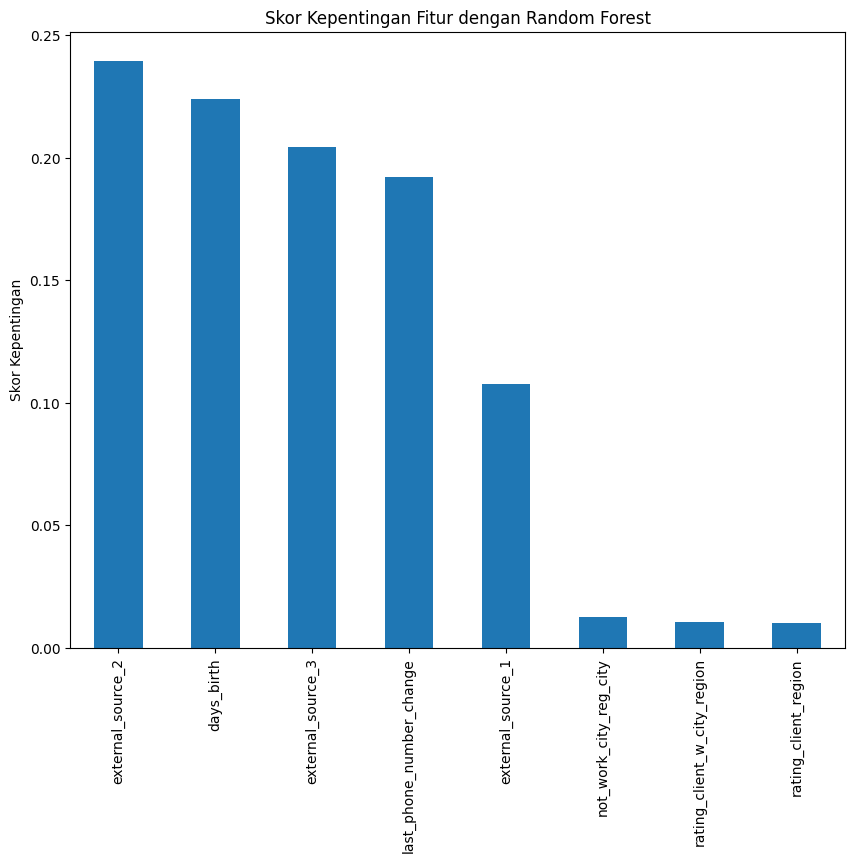

external_source_2              0.239461
days_birth                     0.223693
external_source_3              0.204262
last_phone_number_change       0.192222
external_source_1              0.107370
not_work_city_reg_city         0.012317
rating_client_w_city_region    0.010466
rating_client_region           0.010210
dtype: float64

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Mempersiapkan data
X = df_reduced_corr.drop(columns='target')
y = df_reduced_corr['target']

# Melatih model Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Mendapatkan skor kepentingan fitur
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Visualisasi skor kepentingan fitur
plt.figure(figsize=(10, 8))
feature_importances.plot.bar()
plt.title('Skor Kepentingan Fitur dengan Random Forest')
plt.ylabel('Skor Kepentingan')
plt.show()

feature_importances


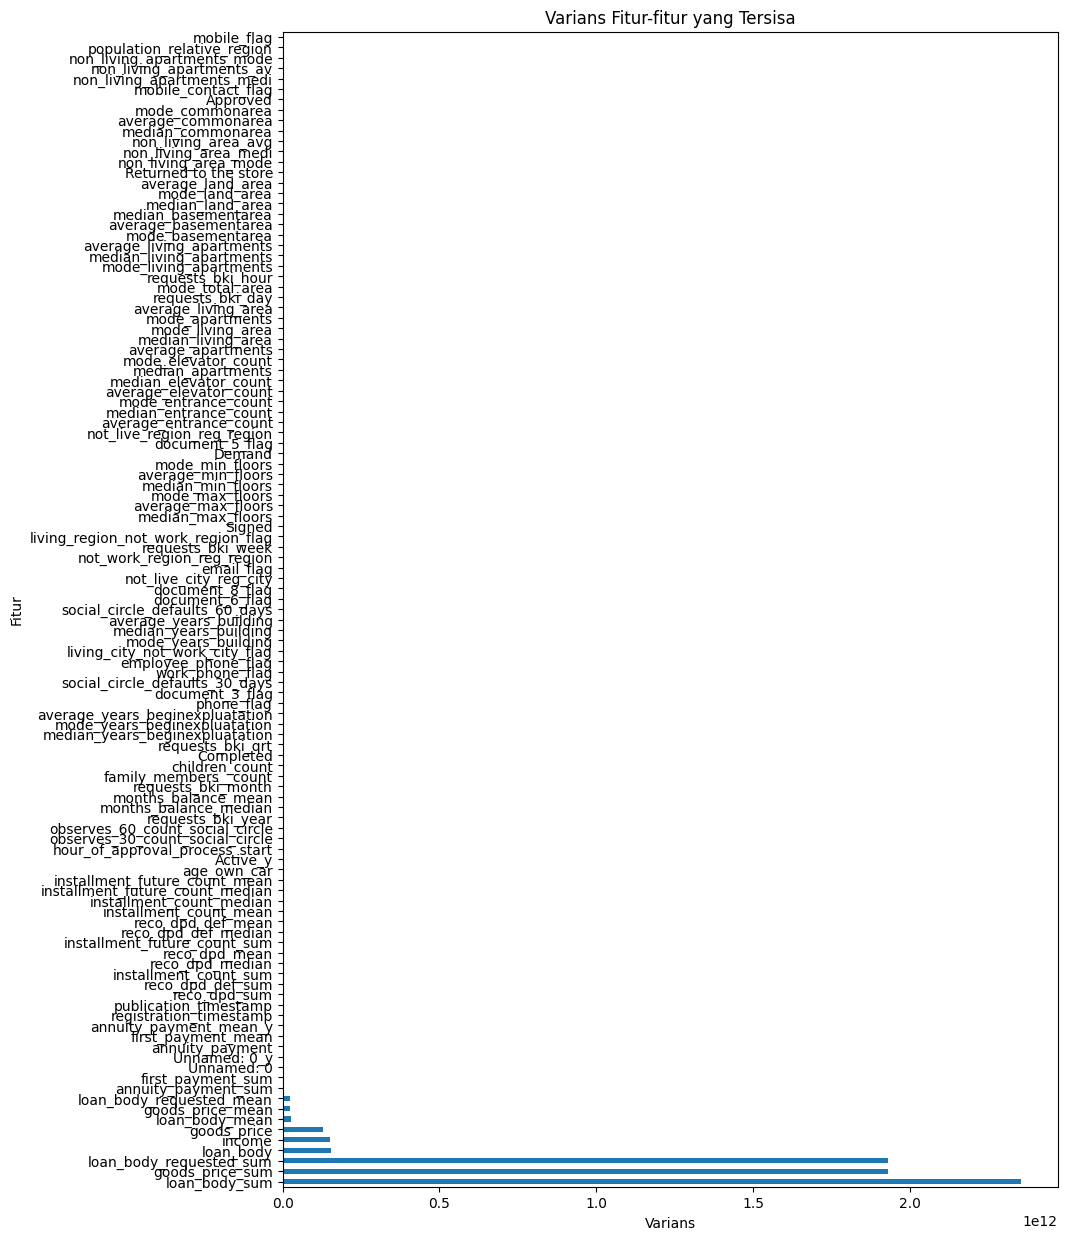

loan_body_sum                 2.353891e+12
goods_price_sum               1.931811e+12
loan_body_requested_sum       1.930586e+12
loan_body                     1.547221e+11
income                        1.515027e+11
                                  ...     
non_living_apartments_medi    6.686321e-04
non_living_apartments_av      6.682997e-04
non_living_apartments_mode    6.491485e-04
population_relative_region    1.815347e-04
mobile_flag                   0.000000e+00
Length: 111, dtype: float64

In [23]:
import numpy as np

# Menyaring dataset untuk fitur numerik yang belum dipertimbangkan
remaining_features = df_cleaned_40.drop(columns=relevant_features).select_dtypes(include=[np.number])

# Menghitung varian untuk fitur-fitur yang tersisa
feature_variances = remaining_features.var().sort_values(ascending=False)

# Visualisasi varian fitur-fitur yang tersisa
plt.figure(figsize=(10, 15))
feature_variances.plot.barh()
plt.title('Varians Fitur-fitur yang Tersisa')
plt.xlabel('Varians')
plt.ylabel('Fitur')
plt.show()

feature_variances


In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Menambahkan konstan untuk perhitungan VIF
X_vif = sm.add_constant(remaining_features)

# Menghitung VIF untuk setiap fitur
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Menyaring fitur dengan VIF di bawah 10 (sebagai contoh)
selected_features_vif = vif_data[vif_data["VIF"] < 10]["Feature"].drop(index=0)  # Menghapus konstan

# Menampilkan jumlah fitur sebelum dan sesudah analisis VIF
num_features_before_vif = remaining_features.shape[1]
num_features_after_vif = len(selected_features_vif)

num_features_before_vif, num_features_after_vif


c:\Users\basnugroho\python-projects\telkom_athon_ds_competition\venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


(111, 42)

In [26]:
# Menghitung jumlah total kolom saat ini di dataset
total_columns = df_cleaned_40.shape[1]
total_columns

133

In [29]:
# Menghitung persentase missing values untuk setiap kolom
missing_percentage = df_cleaned_40.isnull().mean() * 100

# Menyaring kolom dengan lebih dari 30% missing values
columns_with_high_missing = missing_percentage[missing_percentage > 30].index

# Menampilkan fitur dengan persentase missing values yang tinggi
high_missing_data = pd.DataFrame({
    'Feature': columns_with_high_missing,
    'Missing Percentage (%)': missing_percentage[columns_with_high_missing].values
}).sort_values(by='Missing Percentage (%)', ascending=False)

print(high_missing_data)

Empty DataFrame
Columns: [Feature, Missing Percentage (%)]
Index: []


In [30]:
# Menghitung persentase baris dengan nilai 0 untuk setiap kolom
zero_percentage = (df_cleaned_40 == 0).mean() * 100

# Menyaring kolom dengan persentase nilai 0 yang signifikan
columns_with_high_zeros = zero_percentage[zero_percentage > 30].index

# Menampilkan fitur dengan persentase nilai 0 yang tinggi
high_zeros_data = pd.DataFrame({
    'Feature': columns_with_high_zeros,
    'Zero Percentage (%)': zero_percentage[columns_with_high_zeros].values
}).sort_values(by='Zero Percentage (%)', ascending=False)

high_zeros_data


,Feature,Zero Percentage (%)
76,Demand,99.966654
77,Approved,99.825976
74,Returned to the store,99.724897
63,requests_bki_day,99.495644
62,requests_bki_hour,99.414364
...,...,...
14,average_years_beginexpluatation,48.996499
28,mode_years_beginexpluatation,48.907924
54,mode_total_area,48.502563
78,first_payment_mean,30.783419


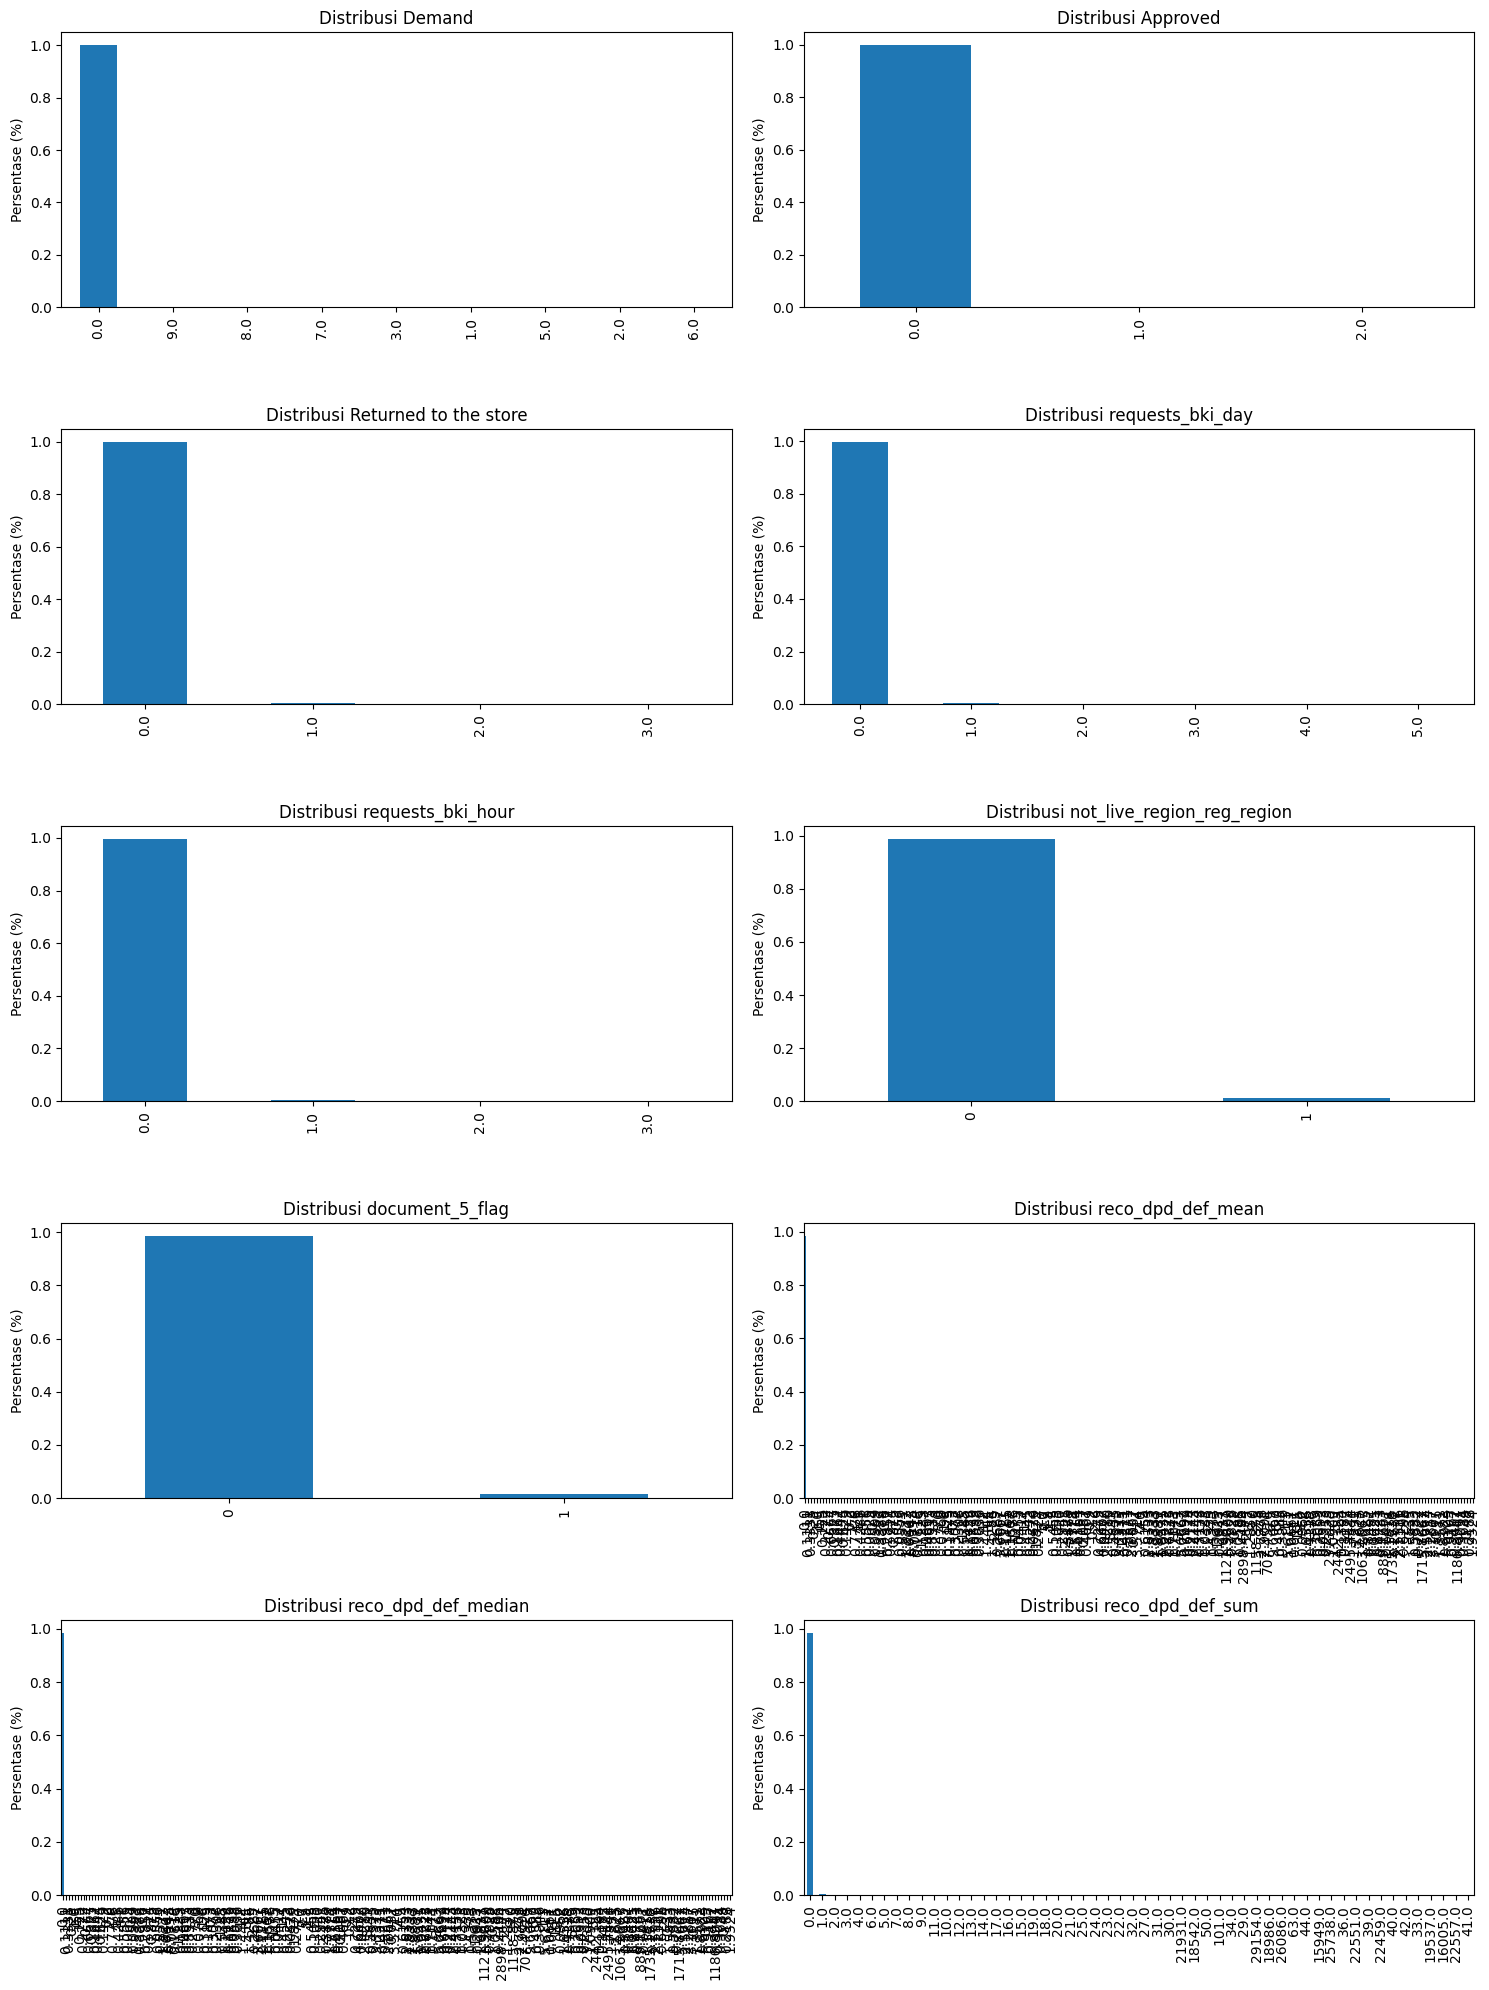

In [31]:
# Memilih 10 fitur dengan persentase nilai 0 tertinggi
top_zero_features = high_zeros_data['Feature'].head(10)

# Membuat visualisasi untuk fitur-fitur tersebut
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for i, feature in enumerate(top_zero_features):
    df_cleaned_40[feature].value_counts(normalize=True).plot.bar(ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Distribusi {feature}')
    axes[i // 2, i % 2].set_ylabel('Persentase (%)')

plt.tight_layout()
plt.show()


In [32]:
# Mengambil 10 fitur dengan persentase nilai 0 tertinggi untuk ditampilkan
high_zeros_percentage = zero_percentage[columns_with_high_zeros].sort_values(ascending=False)

high_zeros_percentage


Demand                             99.966654
Approved                           99.825976
Returned to the store              99.724897
requests_bki_day                   99.495644
requests_bki_hour                  99.414364
                                     ...    
average_years_beginexpluatation    48.996499
mode_years_beginexpluatation       48.907924
mode_total_area                    48.502563
first_payment_mean                 30.783419
first_payment_sum                  30.783419
Length: 80, dtype: float64

In [33]:
# Menghapus kolom dengan persentase nilai 0 lebih dari 30%
df_cleaned_zero = df_cleaned_40.drop(columns=columns_with_high_zeros)

# Menampilkan ukuran dataset sebelum dan sesudah penghapusan
shape_before = df_cleaned_40.shape
shape_after = df_cleaned_zero.shape

shape_before, shape_after


((95964, 133), (95964, 53))

In [34]:
df_cleaned_zero.to_csv('dataset_df_cleaned_zero.csv')

In [39]:
import pandas as pd

# Load the dataset
df_cleaned_zero = pd.read_csv('dataset_df_cleaned_zero.csv')
target_df = pd.read_csv('dataset/DATASET_TARGET.csv')
# add TARGET
df_cleaned_zero = target_df.merge(df, on='reco_id_curr', how='left')
df_cleaned_zero.to_csv('dataset_df_cleaned_zero_target.csv')

# Display the first few rows and basic statistics of the dataset
df_head = df.head()
df_description = df.describe(include='all')

df_head, df_description


(   Unnamed: 0.1                      reco_id_curr contract_type_name gender  \
 0             0  250865db9679b963f8053cea33eb0f86         Cash loans      M   
 1             1  73e474ce3790236a26bb05cc806b254d         Cash loans      F   
 2             2  bbead8b3dd56a68ac6744d0028aca009         Cash loans      M   
 3             3  ece1f89b0bfae8748f44c138346ad267         Cash loans      F   
 4             4  16a5efff61d95fd7f8de14d186a69c01         Cash loans      F   
 
   own_car_flag own_realty_flag    income  loan_body  annuity_payment  \
 0            Y               N  180000.0   953460.0          66357.0   
 1            N               N   85500.0   381528.0          14512.5   
 2            Y               Y  405000.0  1006920.0          42660.0   
 3            N               Y   81000.0   286704.0          15682.5   
 4            N               Y   99000.0   450000.0          30573.0   
 
    goods_price  ... Completed Unnamed: 0 annuity_payment_mean_y  \
 0     900

In [36]:
# Check data types of each column
data_types = df.dtypes

data_types


Unnamed: 0.1                         int64
reco_id_curr                        object
contract_type_name                  object
gender                              object
own_car_flag                        object
own_realty_flag                     object
income                             float64
loan_body                          float64
annuity_payment                    float64
goods_price                        float64
type_suite_name                     object
income_type_name                    object
education_type_name                 object
family_status_name                  object
housing_type_name                   object
population_relative_region         float64
days_birth                           int64
registration_timestamp             float64
publication_timestamp                int64
mobile_flag                          int64
employee_phone_flag                  int64
mobile_contact_flag                  int64
type_of_occupation                  object
family_memb

In [37]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()

# Filter out columns with missing values
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

missing_values_percentage = (missing_values / len(df)) * 100

missing_values, missing_values_percentage


(Series([], dtype: int64), Series([], dtype: float64))

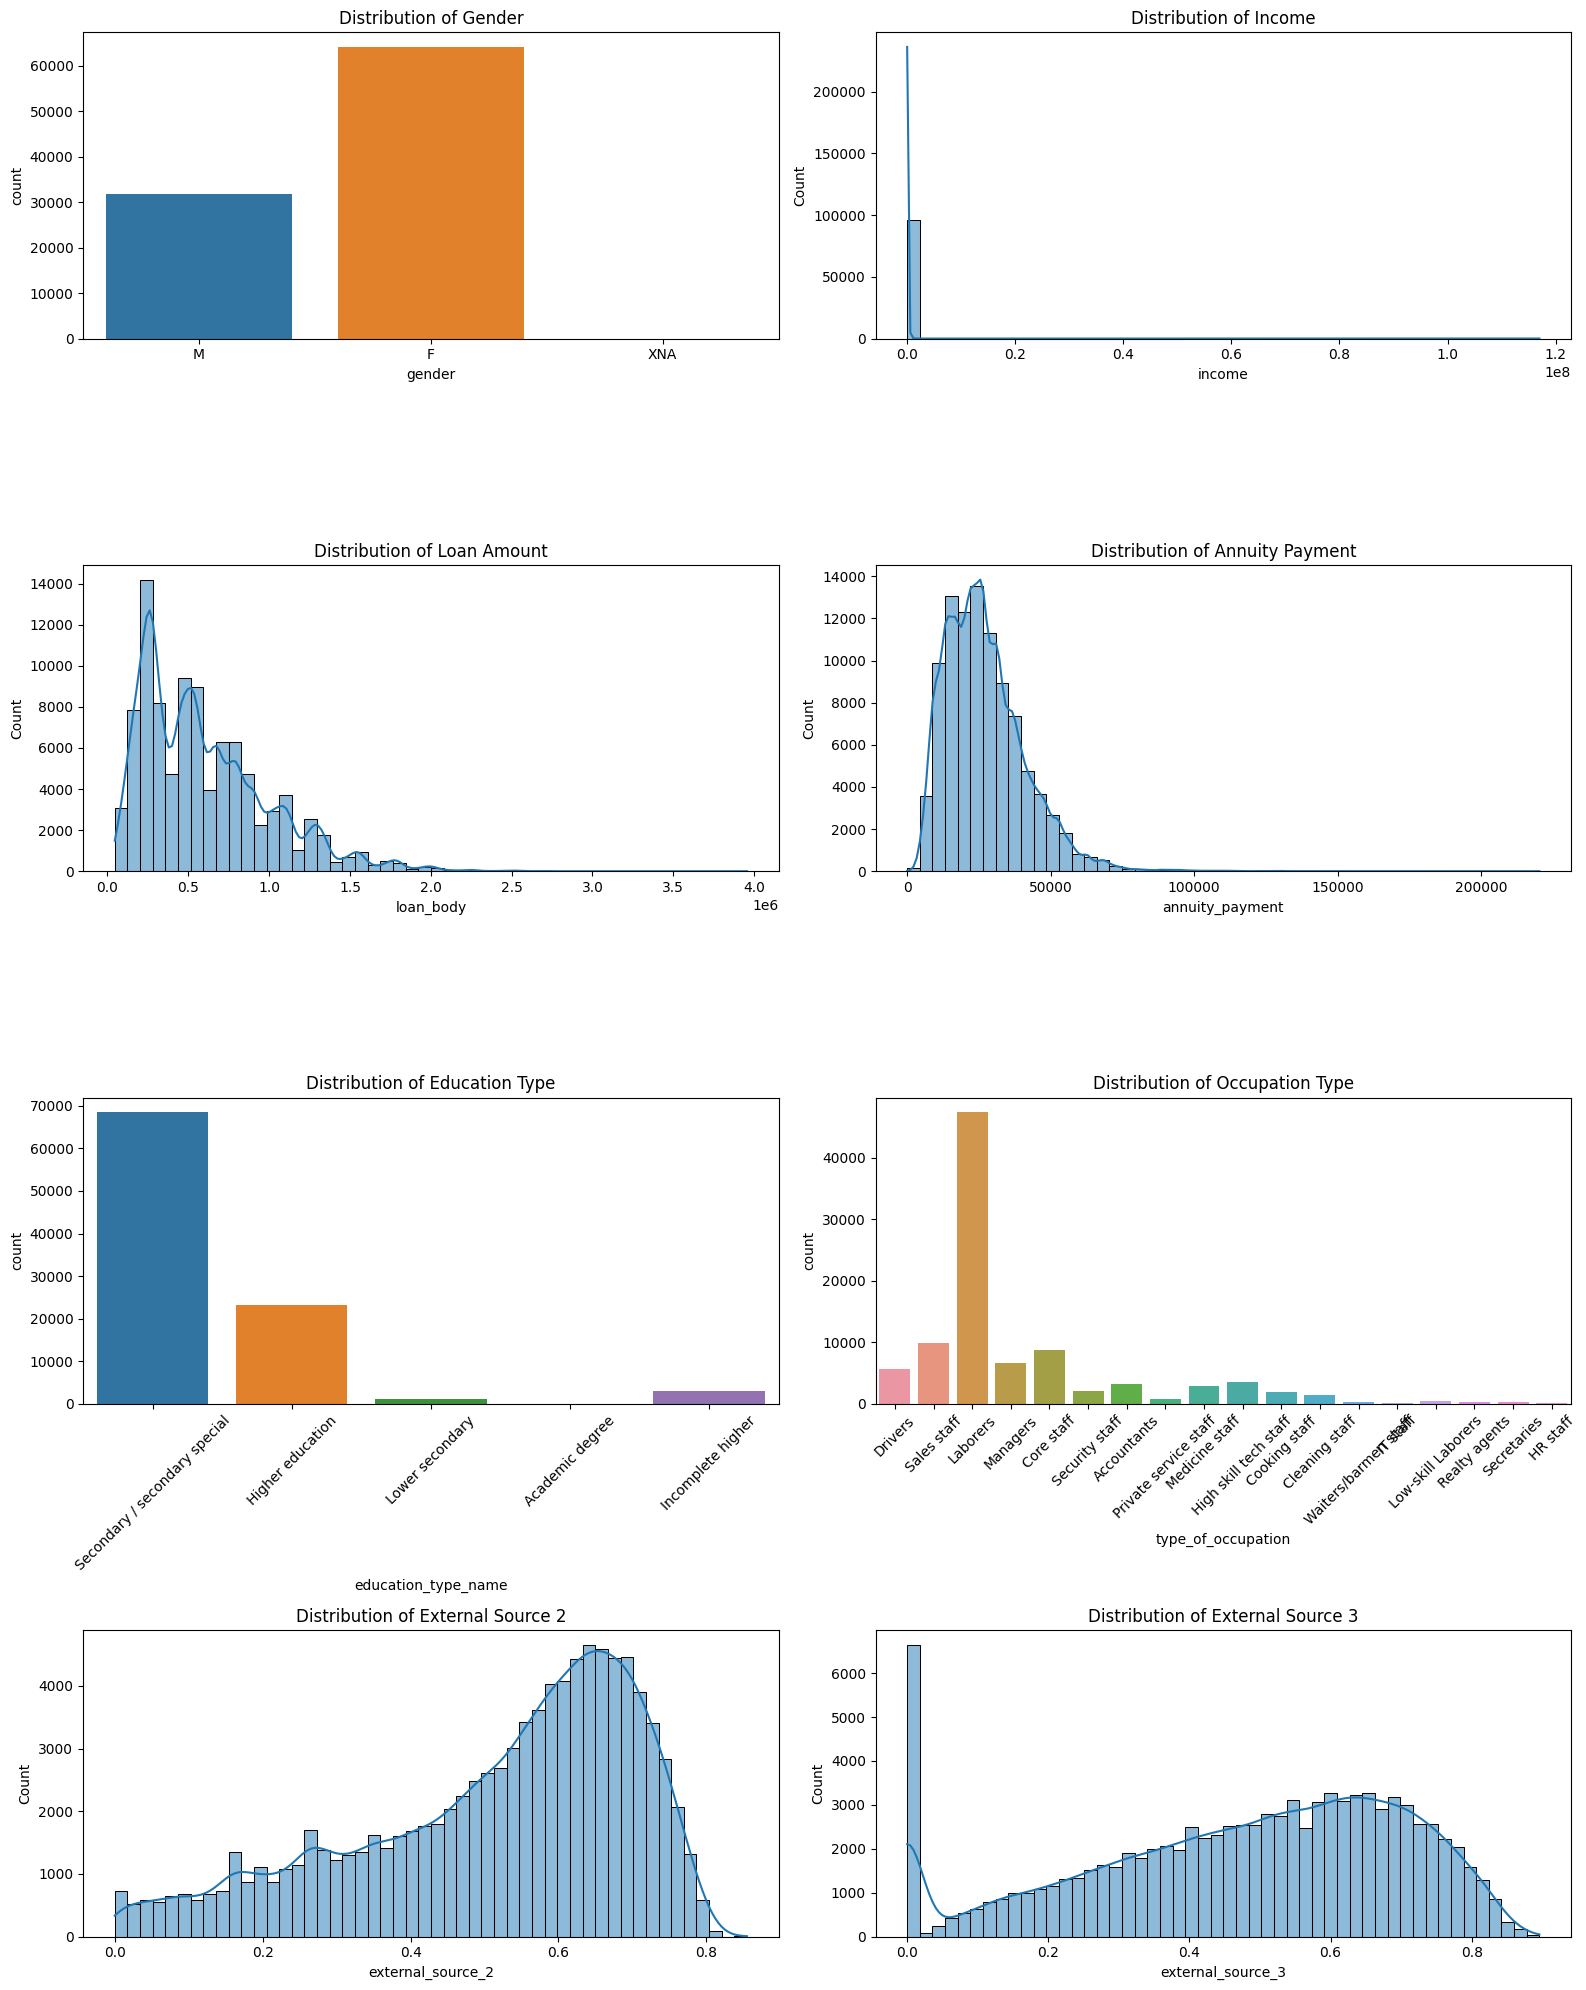

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure and axes
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))

# Plotting for each selected column
sns.countplot(data=df, x='gender', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Gender')

sns.histplot(data=df, x='income', bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Income')

sns.histplot(data=df, x='loan_body', bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Loan Amount')

sns.histplot(data=df, x='annuity_payment', bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Annuity Payment')

sns.countplot(data=df, x='education_type_name', ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Education Type')
axes[2, 0].tick_params(axis='x', rotation=45)

sns.countplot(data=df, x='type_of_occupation', ax=axes[2, 1])
axes[2, 1].set_title('Distribution of Occupation Type')
axes[2, 1].tick_params(axis='x', rotation=45)

sns.histplot(data=df, x='external_source_2', bins=50, kde=True, ax=axes[3, 0])
axes[3, 0].set_title('Distribution of External Source 2')

sns.histplot(data=df, x='external_source_3', bins=50, kde=True, ax=axes[3, 1])
axes[3, 1].set_title('Distribution of External Source 3')

# Adjust layout
plt.tight_layout()
plt.show()


In [40]:
df_target = pd.read_csv('dataset_df_cleaned_zero_target.csv')
df_target.head()

,Unnamed: 0.2,reco_id_curr,target,Unnamed: 0.1,contract_type_name,gender,own_car_flag,own_realty_flag,income,loan_body,...,Completed,Unnamed: 0,annuity_payment_mean_y,annuity_payment_sum,loan_body_requested_mean,loan_body_requested_sum,loan_body_mean,loan_body_sum,goods_price_mean,goods_price_sum
0,0,e0166010fe66a2657549fcf268d12191,0,63456,Cash loans,M,N,Y,202500.0,743031.0,...,1.0,83644.0,12083.287109,24166.574219,229720.50,459441.0,229720.50,459441.0,229720.50,459441.0
1,1,b335548b6f64284f3a01a99ad6a20c87,0,61962,Cash loans,M,N,Y,247500.0,539100.0,...,0.0,66712.0,10626.052734,21252.105469,93903.75,187807.5,105601.50,211203.0,93903.75,187807.5
2,2,704f72562168940fbfa7e9f01e0f84aa,0,18157,Revolving loans,F,N,Y,180000.0,540000.0,...,0.0,41847.0,13312.439941,53249.759766,71606.25,286425.0,73507.50,294030.0,71606.25,286425.0
3,3,02e086b1d018780e83983db8ad5996a3,0,50970,Cash loans,F,Y,Y,90000.0,1125000.0,...,1.0,1072.0,3302.505005,19815.030029,47340.75,284044.5,54995.25,329971.5,47340.75,284044.5
4,4,16e41a0c7ed817b691e1895c0a7cef2a,0,67700,Cash loans,F,N,Y,180000.0,679500.0,...,7.0,8671.0,14340.764974,43022.294922,312939.00,938817.0,310350.00,931050.0,312939.00,938817.0


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics
sns.set_style("whitegrid")
plt.figure(figsize=(15, 20))

# List of columns to visualize
cols_to_viz = ['gender', 'own_car_flag', 'own_realty_flag', 'income', 'loan_body', 'annuity_payment', 
               'goods_price', 'education_type_name', 'income_type_name', 'family_status_name', 'housing_type_name']


<Figure size 1500x2000 with 0 Axes>

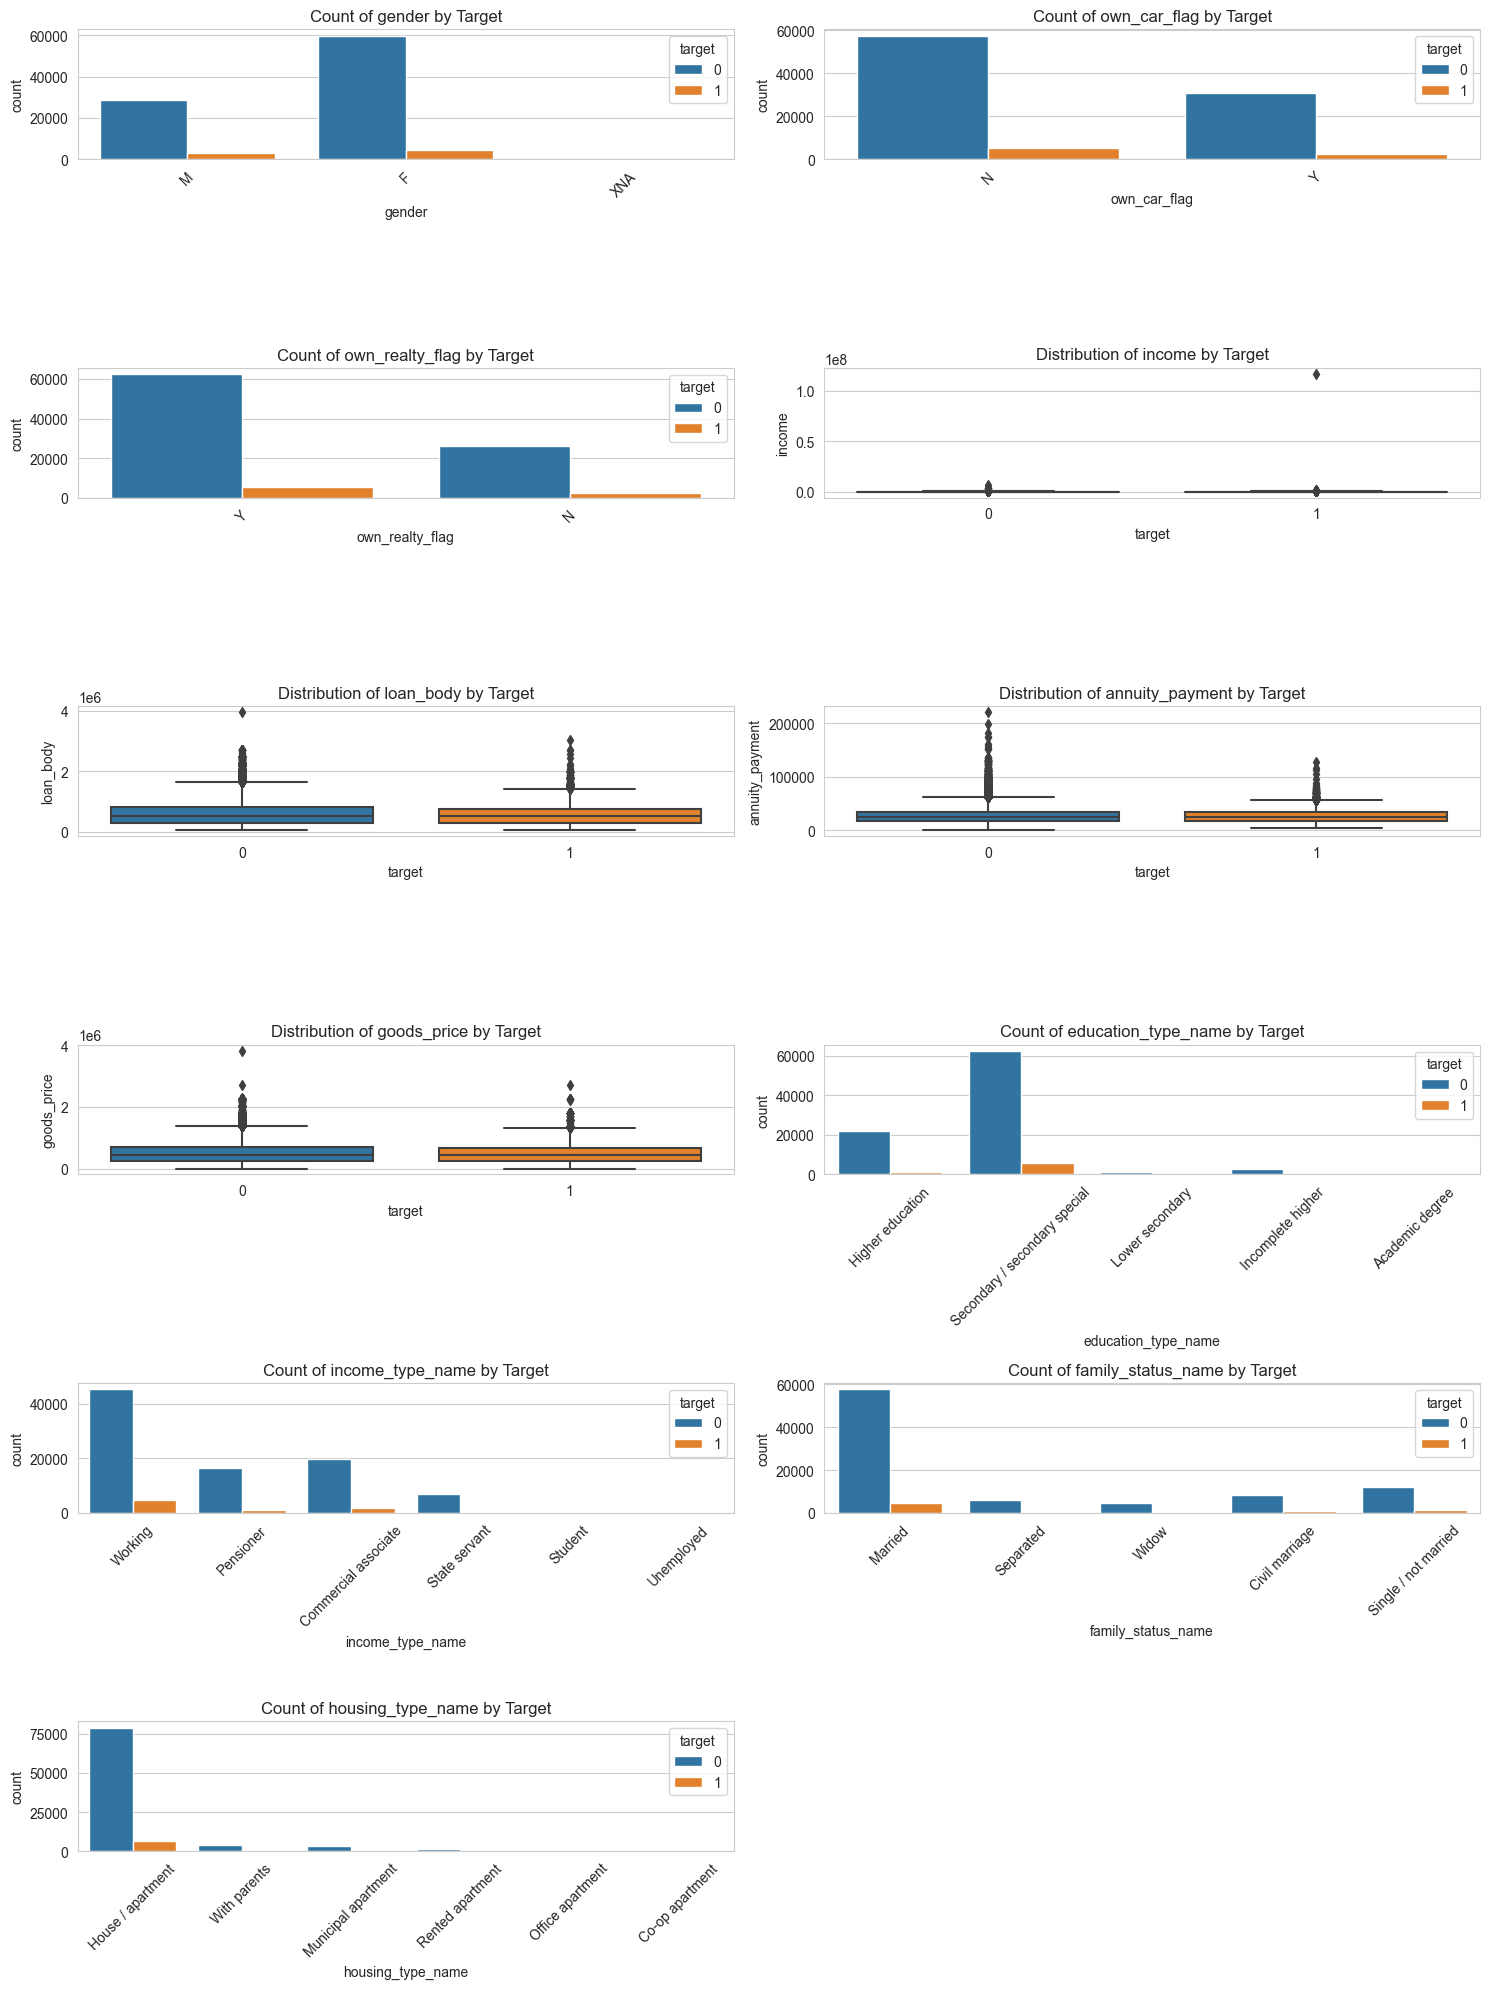

In [43]:
# Visualization considering the "target" column
plt.figure(figsize=(15, 20))

# Plot each column with respect to "target"
for i, col in enumerate(cols_to_viz, 1):
    plt.subplot(6, 2, i)
    
    # For numeric columns, use boxplot
    if df_target[col].dtype in ['int64', 'float64']:
        sns.boxplot(x="target", y=col, data=df_target)
        plt.title(f"Distribution of {col} by Target")
    # For categorical columns, use countplot
    else:
        sns.countplot(x=col, hue="target", data=df_target)
        plt.title(f"Count of {col} by Target")
        plt.xticks(rotation=45)
    
    plt.tight_layout()

plt.show()
